<a href="https://colab.research.google.com/github/ryuji0123/Caption/blob/master/caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#自由に書き換える部分
USER_TOKEN = 'slack の user token'
USER_ID = 'slack の user id'
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/Caption/pytorch-tutorial/tutorials/03-advanced/image_captioning/img/cat.jpg'

In [0]:
SLACK_URL = 'https://slack.com/api/users.profile.set'
MONJIROU_URL = 'http://monjiro.net/'
GOOGLE_API = 'https://script.google.com/macros/s/AKfycbzZtvOvf14TaMdRIYzocRcf3mktzGgXvlFvyczo/exec?text={text}&source=en&target=ja'

In [0]:
try:
  is_executed
except:
  #import modules
  import requests
  from requests import get
  import json
  import subprocess
  import torch
  import matplotlib.pyplot as plt
  import numpy as np 
  import argparse
  import pickle 
  import os
  import re
  import glob
  from bs4 import BeautifulSoup

  #nlp
  !pip install mecab-python3
  !pip install "https://github.com/megagonlabs/ginza/releases/download/latest/ginza-latest.tar.gz"
  import MeCab
  import gensim
  from django.utils import html

  import pkg_resources, imp
  imp.reload(pkg_resources)
  import spacy

  
  nlp = spacy.load('ja_ginza')
  mecab = MeCab.Tagger()
  word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/Caption/model.vec')

  # caption
  %cd /content/drive/My Drive/Colab Notebooks/Caption
  # !git clone https://github.com/yunjey/pytorch-tutorial.git
  %cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
  !pip install -r requirements.txt


  from torchvision import transforms 
  from build_vocab import Vocabulary
  from model import EncoderCNN, DecoderRNN
  from PIL import Image
  # Device configuration
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # scraping
  !apt-get update
  !apt install chromium-chromedriver
  !cp /usr/lib/chromium-browser/chromedriver /usr/bin
  !pip install selenium
  from selenium import webdriver
  from selenium.webdriver.chrome.options import Options


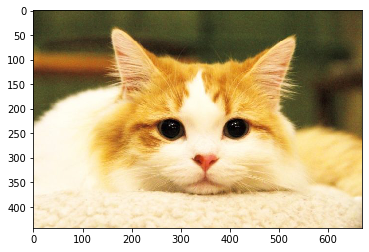

In [0]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main():
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # Prepare an image
    image = load_image(image_path, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    plt.show()
    return sentence
    
if __name__ == '__main__':
    encoder_path ='models/encoder-2-1000.ckpt'
    decoder_path ='models/decoder-2-1000.ckpt'
    vocab_path ='data/vocab.pkl'
    
    # Model parameters (should be same as paramters in train.py)
    embed_size=256
    hidden_size=512
    num_layers=1
    
    files = sorted(glob.glob(IMG_PATH))
    for i, image_path in enumerate (files):   
        caption = main()

In [0]:
caption = re.sub(r'<[a-z]+>', '', caption)
print(caption)

 a cat is laying on a bed with a cat . 


In [0]:
#translate from English into Japanese
google_translation_url = GOOGLE_API.format(text=caption)
ja_caption = json.loads(get(google_translation_url).text)['text']
print(ja_caption, type(ja_caption))

 猫は猫とベッドに横たわっています。 <class 'str'>


In [0]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)
driver.implicitly_wait(10)

In [0]:
driver.get(MONJIROU_URL)
text_area = driver.find_element_by_name('before')
text_area.clear()
text_area.send_keys(ja_caption)
driver.find_element_by_id('button').click()

In [0]:
html_ = driver.page_source.encode('utf-8')
soup = BeautifulSoup(html_, 'html.parser')
ja = soup.find('div', class_="section type42").find('p', class_='text').get_text()
ja_caption = ja.replace('▼武士語 by http://monjiro.net/&zmp;#壱陸零;', '')
print(ja_caption)

猫は猫と布団に横たわとはいるでござる。


In [0]:
with open('/content/drive/My Drive/Colab Notebooks/Caption/data.json') as f:
  data = json.load(f)
for d in data[:10]:
  print(d)

{'slack_icon': ':joy:', 'description': '嬉し泣き'}
{'slack_icon': ':heart_eyes:', 'description': '目がハートの笑顔'}
{'slack_icon': ':sob:', 'description': '大泣き'}
{'slack_icon': ':blush:', 'description': 'にこにこ'}
{'slack_icon': ':unamused:', 'description': 'しらけた'}
{'slack_icon': ':kissing_heart:', 'description': '投げキッス'}
{'slack_icon': ':two_hearts:', 'description': '2つのハート'}
{'slack_icon': ':weary:', 'description': 'あきらめ'}
{'slack_icon': ':ok_hand:', 'description': 'OKの手'}
{'slack_icon': ':pensive:', 'description': 'しょぼーん'}


In [0]:
class Slack(object):
  def __init__(self, data, caption):
    self.data = data
    self.caption = caption
  
  def extractWords(self): 
    doc = nlp(self.caption)
    tokens = []
    for sent in doc.sents:
        for token in sent:
            tokens.append(token)

    for token in tokens:
        if token.dep_ in  ["nsubj", "iobj"]:
            return [token.lemma_]
        
    lines = mecab.parse(self.caption).split('\n')
    nouns = []
    for line in lines:
      feature = line.split('\t')
      if len(feature) == 2: 
        info = feature[1].split(',')
        hinshi = info[0]
        if hinshi in ('名詞'):
            nouns.append(info[6])
    return nouns
  
  def calcSimilarity(self):
    words = self.extractWords()
    pair = [self.data[0], words[0], 0]
    for d in self.data:
      for w in words:
        try:
         sim = word2vec_model.similarity(w, d['description'])
         if sim > pair[2]:
           pair = [d, w, sim]
        except:
          continue
    print(pair)
    return pair

  def changeStatus(self):
    text, emoji = self.caption, self.calcSimilarity()[0]['slack_icon']
    data = {
        'token': USER_TOKEN,
        'user': USER_ID,
        'profile': json.dumps({
            'status_text': text,
            'status_emoji': emoji
        })
    }
    res = requests.post(SLACK_URL, params=data)
    print(res)

In [0]:
slack = Slack(data, ja_caption)
slack.changeStatus()

[{'slack_icon': ':cat2:', 'description': 'ネコ'}, '猫', 0.69484663]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<Response [200]>


In [0]:
is_executed = True